In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math

# K-means

In [17]:
from numbers import Real
def get_difference(pair):
    """
    *parameters
        -pair type value list/tuple of numerical values
        -return type value float
    *implementations
        -verification of input type (is list, tuple, contains numerical real values ?)    
    """
    if not isinstance(pair, (list, tuple)) or len(pair) != 2:
        raise ValueError("Pass a list/tuple with exactly two numbers.")
    a, b = pair
    if not isinstance(a, Real) or not isinstance(b, Real):
        raise TypeError("Both values must be real numbers.")
    return abs(a - b)

In [19]:
def calculate_distance(ptA,ptB):
    """
    *parameters 
        -ptA,ptB value type : (x1,y1,z1,..) and (x2,y2,z2,..)
        -return float
    *implementations
        -some safety check
    """
    if not isinstance(ptA,(list,tuple)) or not isinstance(ptB,(list,tuple)):
        raise ValueError("Expect input with points in tuple or list")
    if len(ptA) == len(ptB): 
        #ZIP IT
        zipped = [ptA,ptB]
        squared_sum = 0.0
        #Just some calculations folks
        for coords in zip(*zipped):
            squared_sum += math.pow(get_difference(coords),2)
        return math.sqrt(squared_sum)
    else :
        raise ValueError("Size missmatched :)\nPs : Did you know size matters ?")
#testing
#print(calculate_distance((1,3,4),(2,2,8)))
#print(calculate_distance((1,3),(2,2)))
#print(calculate_distance((1,3,4,6,7,8),(1,3,"7",6,7,7)))
#print(calculate_distance((1,"h"),(2,2)))

In [21]:
#calculer les distances pour chaque point par rapport aux autres points (classifie ou noyaux)
def get_shortestDistancePairs(classified_pts : list = None ,unclassified_pts : list = None ,classify_classified : bool = False):
    """
    *parameters
        -classified_pts : points used to classify unclassified points ( type : [(x1,y1,..),(x2,y2,..),..] )
        -unclassified_pts : points to be classified ( type : [(x1,y1,..),(x2,y2,..),..] )
        -classify_classified : just to make sure classified points classify itself (type : true/flase)
        -return type : {keys : points, values : classified points}
    *implementations
        -deterministic tie break for points that get same distance with 2 separated centroids, use lexicography comparison, the lowest lexi centroid
        gets the point.
    """
    pairs = {}
    #loop through unclassified points
    for uc_pt in unclassified_pts :
        shortest_distance = 0.0
        nearest_neighbour = None
        #loop through classified points
        for i,c_pt in enumerate(classified_pts) :
            distance = calculate_distance(uc_pt,c_pt)
            if distance < shortest_distance  or shortest_distance == 0 :
                shortest_distance = distance
                nearest_neighbour = c_pt
            elif math.isclose(distance,shortest_distance) :
                #implementing deterministic tie break condition, mean to determine a fixed/conditional outcome when tie break condition satisfies
                min_lexi_pt = min([c_pt,classified_pts[i-1]])
                nearest_neighbour = min_lexi_pt
        pairs[uc_pt] = nearest_neighbour
    if classify_classified : 
        for c_pt in classified_pts :
            pairs[c_pt] = c_pt       
    return pairs # return value type : {keys : points, values : classified points}

In [23]:
#trouver la moyen de chaque vecteur par example : dimension Y qui a 3 points, il va prendre la somme des 3 points et diviser par 3, 
#points flexible number of dimensiosn -> [(x1,y1,...), (x2,y2,...), ...]
def get_centroid(points : list = None):
    """
    - points value type : [(x1,y1,z1,..),(x2,y2,z2,..),..]
    - return value type : (x_mean,y_mean,z_mean,..)

    calculation : 
        #1> get sum of values in all dimensions x1+x2+x3+...+xn
        #2> get average values in all dimensions sum_x/len_x 
        #3> output x_mean,y_mean,..
    """
    #safety conditions
    if not points :
        return None
    else :
        generalized_num_dims = len(points[0])
        if any(len(point) != generalized_num_dims for point in points):
            raise ValueError("points inconsitent dimensions")

    #return (x_mean,y_mean,..)
    return tuple(sum(coords)/len(points) for coords in zip(*points)) #zip(*points) -> [x1,x2,..],[y1,y2,..],..

In [54]:
def get_centroids(k : int = 3 ,points : list = None, centroids : list = None, 
                  float_precision : int = None,max_recursion_depth : int = 999,recursion_iter : int = 0):
    """
    *parameters
    - k -> number of centroids.
    - points value type : [(x1,y1,z1,..),(x2,y2,z2,..),..], points to be assigned to centroids.
    - centroids value type : [(x1,y1,z1,..),(x2,y2,z2,..),(x3,y3,z3,..)], len(centroids) = k, this parameter is passed in to optimize it's positions,
    if not, the function will generate random intialization.
    - float_precision value type int, to get which float number to round up to, not likely use
    - return value type centroids

    *logic & conditions 
        *process
        #1> intialize centroids position randomly if not given
        #2> pair points to it's centroid
        #3> recursion stops when calculated inertia don't decrease or if centroids coordinations stop changing 

        *implementations
        -handling empty clusters
        -prevent duplication of centroid in random initialization process
        -recursivity
        -max recursion depth
        -sort centroids positions in list to prevent accidental swaps (created for centroids coordinations verification)
        -float precision, in case if centroids coordinations can't get stable (this is optional in parameter)
        -inertia control, measure the compacity of each cluster, in theory, inertia should always decrease, if it stops decreasing -> recursion stops
    """
    #safety checks 
    if not points or not k:
        return None
    elif recursion_iter == max_recursion_depth :
        if centroids :
            return centroids
        else :
            return None
    else :
        #centroids random intitialization
        if centroids == None :
            centroids = []
            while(len(centroids)<k):
                rand = np.random.randint(0,len(points))
                if points[rand] not in centroids :
                    centroids.append(points[rand])
        #pair points to centroids
        pairs = get_shortestDistancePairs(centroids,points) # pairs value type : {keys : points , values : assigned centroid}
        #stabilize centroids's coordinations
        new_centroids = []
        for centroid in centroids :
            cluster = []
            for key,value in pairs.items():
                if value == centroid :
                    cluster.append(key)
            if len(cluster) > 0 :
                new_centroids.append(get_centroid(cluster)) #get_centroid() return tuple (x,y,z,..)
            else :
                #if cluster is empty, keep it's previous centroid's coordinations
                new_centroids.append(centroid)
        #if float_precision, round centroids's coordinations to float precision
        if float_precision :
            centroids = [tuple(round(v, float_precision) for v in c) for c in centroids]
            new_centroids= [tuple(round(v, float_precision) for v in c) for c in new_centroids]
        #stop condition : check centroids's new,old coordinations or inertia increase/doesn't change
        if (sorted(centroids) == sorted(new_centroids)) or (
            get_inertia(centroids = centroids,points=points) < get_inertia(centroids = new_centroids,points=points)): 
            return centroids
        #if not recall to update new centroids's coordinations without reinitialize randomly
        else :
            return get_centroids(k=k,points=points,centroids=new_centroids,
                                 float_precision=float_precision,max_recursion_depth=max_recursion_depth)

#### Remarque 1 : recursion is infinite due to oscillation of centroids, going back and forth infinitely

<details>
  <summary><b>Observation log (click to expand)</b></summary>
  <div style="font-size:12px; line-height:1.25; max-height:260px; overflow:auto; border:1px solid #ddd; border-radius:6px; padding:8px; margin-top:8px; background:#fafafa;">
<pre>
centroids :  [(0, 3), (6, 3), (5, 3)]

pairs :  {(1, 2): (0, 3), (6, 3): (5, 3), (0, 3): (5, 3), (7, 2): (6, 3), (1, 4): (0, 3), (3, 3): (5, 3), (2, 2): (0, 3), (5, 3): (5, 3), (3, 2): (5, 3)}

group :  [(1, 2), (1, 4), (2, 2)]
group :  [(7, 2)]
group :  [(6, 3), (0, 3), (3, 3), (5, 3), (3, 2)]

centroids :  [(1.33, 2.67), (7.0, 2.0), (3.4, 2.8)]
pairs :  {(1, 2): (1.33, 2.67), (6, 3): (7.0, 2.0), (0, 3): (1.33, 2.67), (7, 2): (3.4, 2.8), (1, 4): (1.33, 2.67), (3, 3): (3.4, 2.8), (2, 2): (1.33, 2.67), (5, 3): (3.4, 2.8), (3, 2): (3.4, 2.8)}

group :  [(1, 2), (0, 3), (1, 4), (2, 2)]
group :  [(6, 3)]
group :  [(7, 2), (3, 3), (5, 3), (3, 2)]

centroids :  [(1.0, 2.75), (6.0, 3.0), (4.5, 2.5)]
pairs :  {(1, 2): (1.0, 2.75), (6, 3): (4.5, 2.5), (0, 3): (1.0, 2.75), (7, 2): (6.0, 3.0), (1, 4): (1.0, 2.75), (3, 3): (4.5, 2.5), (2, 2): (1.0, 2.75), (5, 3): (4.5, 2.5), (3, 2): (4.5, 2.5)}

group :  [(1, 2), (0, 3), (1, 4), (2, 2)]
group :  [(7, 2)]
group :  [(6, 3), (3, 3), (5, 3), (3, 2)]

centroids :  [(1.0, 2.75), (7.0, 2.0), (4.25, 2.75)]

pairs :  {(1, 2): (1.0, 2.75), (6, 3): (7.0, 2.0), (0, 3): (1.0, 2.75), (7, 2): (4.25, 2.75), (1, 4): (1.0, 2.75), (3, 3): (4.25, 2.75), (2, 2): (1.0, 2.75), (5, 3): (4.25, 2.75), (3, 2): (4.25, 2.75)}

group :  [(1, 2), (0, 3), (1, 4), (2, 2)]
group :  [(6, 3)]
group :  [(7, 2), (3, 3), (5, 3), (3, 2)]

centroids :  [(1.0, 2.75), (6.0, 3.0), (4.5, 2.5)]

pairs :  {(1, 2): (1.0, 2.75), (6, 3): (4.5, 2.5), (0, 3): (1.0, 2.75), (7, 2): (6.0, 3.0), (1, 4): (1.0, 2.75), (3, 3): (4.5, 2.5), (2, 2): (1.0, 2.75), (5, 3): (4.5, 2.5), (3, 2): (4.5, 2.5)}

group :  [(1, 2), (0, 3), (1, 4), (2, 2)]
group :  [(7, 2)]
group :  [(6, 3), (3, 3), (5, 3), (3, 2)]
</pre>
  </div>
</details>

<details>
  <summary><b>Notes / Fix ideas (click to expand)</b></summary>
  <div style="font-size:13px; line-height:1.35; border-left:4px solid #bbb; padding-left:10px; margin-top:8px;">
  &raquo; one reason could arise the infinite oscillation error is due to point can have same distance with 2 different centroids, so after each iteration, it can swap back and forth depend on which centroid is being linearly read first by the code.<br>
  &raquo; to fix this, we can implement deterministic tie break (distribute the point to the lexicographically smallest centroid)<br>
  &raquo; also, still can oscillating with very small step, to prevent this, we will compare previous inertia with new inertia if it doesn't decrease then recursion exit*<br>
  </div>
</details>


#### Remarque 2 : centroid return empty group (centroid doesn't have anypoint assigned to it), this problem happen due to centroid
#### being average value, not any point itself in given datapoints, it can happen the centroids steal other centroid's point and leave 
#### some centroids with no points, which then return empty group.

<details>
  <summary><b>Observation log (click to expand)</b></summary>
  <div style="font-size:12px; line-height:1.25; max-height:260px; overflow:auto; border:1px solid #ddd; border-radius:6px; padding:8px; margin-top:8px; background:#fafafa;">
<pre>
&gt;centroids :  [(0, 3), (1, 2), (1, 4)]
pairs :  {(1, 2): (1, 4), (6, 3): (1, 2), (0, 3): (1, 2), (7, 2): (1, 2), (1, 4): (1, 4), (3, 3): (1, 2), (2, 2): (1, 2), (5, 3): (1, 2), (3, 2): (1, 2)}
***group :  []***
group :  [(6, 3), (0, 3), (7, 2), (3, 3), (2, 2), (5, 3), (3, 2)]
group :  [(1, 2), (1, 4)]

centroids :  [(0, 3), (3.71, 2.57), (1.0, 3.0)]
pairs :  {(1, 2): (1.0, 3.0), (6, 3): (3.71, 2.57), (0, 3): (1.0, 3.0), (7, 2): (3.71, 2.57), (1, 4): (1.0, 3.0), (3, 3): (3.71, 2.57), (2, 2): (1.0, 3.0), (5, 3): (3.71, 2.57), (3, 2): (3.71, 2.57)}
***group :  []***
group :  [(6, 3), (7, 2), (3, 3), (5, 3), (3, 2)]
group :  [(1, 2), (0, 3), (1, 4), (2, 2)]

centroids :  [(0, 3), (4.8, 2.6), (1.0, 2.75)]
pairs :  {(1, 2): (1.0, 2.75), (6, 3): (4.8, 2.6), (0, 3): (1.0, 2.75), (7, 2): (4.8, 2.6), (1, 4): (1.0, 2.75), (3, 3): (4.8, 2.6), (2, 2): (1.0, 2.75), (5, 3): (4.8, 2.6), (3, 2): (4.8, 2.6)}
***group :  []***
group :  [(6, 3), (7, 2), (3, 3), (5, 3), (3, 2)]
group :  [(1, 2), (0, 3), (1, 4), (2, 2)]

[(0, 3), (4.8, 2.6), (1.0, 2.75)]
</pre>
  </div>
</details>

<details>
  <summary><b>Note / Fix idea (click to expand)</b></summary>
  <div style="font-size:13px; line-height:1.35; border-left:4px solid #bbb; padding-left:10px; margin-top:8px;">
  &raquo; To solve this problem, we are not gonna delete the centroid, but keep it unchanged for the next iteration.
  </div>
</details>


#### Add monte carlo simulation to get various randomized intialization's results, and pick the best obtained centroids by measuring how compact the clusters are with their centroid

In [30]:
#somme de distance au carré de chaque cluster avec leur noyau
def get_inertia(centroids : list = None, points : list = None):
    """
    *parameters
        -centroids requires 3 points that have numerical coordinations, is list
        -points can have many, is also list
        -return value type : float
    *process
        #1> loop through points
        #2> get distance with it's closest centroid
        #3> add them all together
        #4> return.
    """
    if not points or not centroids:
        raise ValueError("No centroids or points given")
    inertia = 0.0
    try : #catch error the lazy way
        for point in points :
            distances = [math.pow(calculate_distance(centroid,point),2) for centroid in centroids]
            inertia += min(distances)
        return inertia
    except Exception as e :
        raise ValueError("Make sure centroids,points have numerical coordination values")
#print("test : ",get_inertia(centroids = centroids, points = fixed_points))

In [32]:
def run_monteCarlo(k : int = None ,points : list = None,
                  float_precision : int = None,
                  nb_runs : int = 10,
                  max_recursion_depth : int = 999,centroids : tuple = None):
    """
    -this function just do looping to get different results obtained from get_centroids function
    -return value type : list  [[*centroids coordinations*],inertia] / [[(float,float,float,..),..],float]

    *implementations 
        -REMOVE duplication of results (use sorting lexicography and compare centroids's coordinations) -> less computation
        -and some conditions to assure the function run smoothly/efficiently
    """
    list_centroids = []#keep track of obtained centroids to prevent duplication
    list_centroids2inertia = []
    #run the process n times
    for run in range(nb_runs):
        #centroids value type : [(float,float,float)]
        centroids = sorted(get_centroids(k = k,points = points,float_precision = float_precision,
                                         max_recursion_depth = max_recursion_depth,centroids=centroids)) #sorted to assure lexicographically ordered
        inertia = get_inertia(centroids = centroids,points=points) #inertia value type : float
        #after each process , calculate inertia, if conditions (to prevent duplication of centroids) are valid, append centroids and inertia to a list
        if inertia :
            if len(list_centroids) == 0:
                list_centroids2inertia.append([centroids,inertia])
                list_centroids.append(centroids)
            elif centroids not in list_centroids :#verify to prevent duplication
                list_centroids2inertia.append([centroids,inertia])
                list_centroids.append(centroids)
    return list_centroids2inertia #the var name is lame but i can't find better

In [34]:
def get_lowest_inertia_centroids(list_centroids2inertia : list = None):
    """
    *parameters 
        -list_centroids2inertia value type : list [[*centroids coordinations*],inertia] / [[(float,float,float,..),..],float]
    """
    #check all pair, get the min inertia, return the centroids that correspond to the min inertia
    if list_centroids2inertia :
        lowest_inertia_centroids = None
        lowest_inertia = None
        for i,pair in enumerate(list_centroids2inertia) : #pair value type : [[float,float,float],float]
            centroids,inertia = pair #unpacking values, centroids -> [float,float,float], inertia -> float
            if lowest_inertia == None or lowest_inertia > inertia: #condition to find lowest inertia centroids
                lowest_inertia_centroids = centroids
                lowest_inertia = inertia
        return lowest_inertia_centroids #-> [float,float,float]
    else :
        return None

#### Testing K-means algo for different num of dimensions

# Instructions
## `run_monteCarlo()`
Obtain multiple `get_centroids()` results.

**Parameters**
- `k` *(int)* — number of centroids.  
- `points` *(list[tuple[float, ...]])* — dataset (at least 1D).  
- `float_precision` *(int, optional)* — round centroid coordinates.  
- `max_recursion_depth` *(int, optional)* — recursion limit (should not exceed 1000; Python’s default is 1000).  
- `nb_runs` *(int)* — number of `get_centroids()` executions.
- `centroids` *(tuple[float, ...] | None)* — predefined initial centroid coordinates; use `None` for random init.  

**Returns**
- `[[(float, ...), ...], float]` — each item is `[centroids, inertia]`.

---

## `get_lowest_inertia_centroids()`
Extract the best result (lowest inertia) from `run_monteCarlo()` output.

**Parameters**
- `list_centroids2inertia` *(list)* — items shaped like `[[(float, ...), ...], float]`.

**Returns**
- `tuple[float,..]` — coordinates of the lowest-inertia centroids. 

---

## `get_centroids()`
Compute a single k-means solution.

**Parameters**
- `k` *(int)* — number of centroids.  
- `points` *(list[tuple[float, ...]])* — dataset (at least 1D).  
- `float_precision` *(int, optional)* — round centroid coordinates.  
- `max_recursion_depth` *(int, optional)* — recursion limit (≤ 1000).  
- `centroids` *(tuple[float, ...] | None)* — predefined initial centroid coordinates; use `None` for random init.  
- `get_graphs` *(bool, optional)* — if `True`, output graphs.  
- `graph_title` *(str, optional)* — title for graphs.  
- `save_as` *(str, optional)* — filename to save graphs.
- `save_graph`*(bool,optional)* - save or not.

**Returns**
- `list[tuple[float, ...]]` — centroid coordinates (and optionally inertia, depending on your implementation).


### Test

In [47]:
#sample points
samplePts1d = [
    # Cluster A ~ -5
    (-6,), (-5,), (-4,), (-5,), (-6,), (-5,), (-4,), (-5,), (-6,), (-4,),
    # Cluster B ~ 0
    (-1,), (0,), (1,), (0,), (-1,), (1,), (0,), (0,), (1,), (-1,),
    # Cluster C ~ 7
    (6,), (7,), (8,), (7,), (6,), (8,), (7,), (7,), (6,), (8,)
]

samplePts2d = [
    # cluster ~ (0, 0)  (more spread)
    (-1.80,  0.90),
    ( 2.40, -1.20),
    (-2.10, -0.50),
    ( 1.70,  2.20),
    (-2.60,  1.10),
    ( 2.80,  0.40),
    ( 0.60, -2.70),
    (-1.90, -1.40),
    ( 3.10, -0.80),
    (-0.70,  2.90),
    ( 1.20, -2.10),
    (-2.80,  0.20),

    # cluster ~ (4.5, 4.0)  (more spread)
    ( 6.30,  5.80),
    ( 3.20,  6.50),
    ( 7.10,  3.60),
    ( 5.90,  1.90),
    ( 2.40,  3.20),
    ( 4.80,  6.10),
    ( 6.90,  4.90),
    ( 3.80,  1.80),
    ( 5.50,  2.20),
    ( 2.90,  5.70),
    ( 4.10,  1.60),
    ( 6.20,  2.70),

    # cluster ~ (-4.0, 3.5)  (more spread)
    (-6.70,  5.90),
    (-1.50,  6.20),
    (-7.30,  2.10),
    (-2.20,  1.70),
    (-5.80,  0.90),
    (-3.10,  6.80),
    (-4.90,  5.50),
    (-1.80,  2.60),
    (-6.20,  4.00),
    (-2.70,  5.90),
    (-5.50,  2.20),
    (-3.40,  0.70),
]
samplePts5d = [
(-0.1729, -0.2075, -0.1336,  0.8424, -0.1531),
(-1.7968,  0.3988, -0.3208, -0.2604,  0.1391),
( 0.2788,  1.3963,  0.7880,  0.1326, -0.8860),
(-1.2176,  0.2956,  1.5733,  0.0500, -0.1276),
( 0.6381, -1.7443, -0.3747,  0.5884,  1.0481),
(-0.0195, -0.1437, -1.5710, -0.7634,  0.6780),
( 0.1147, -0.1907, -0.2102,  0.1664,  0.5856),
( 0.4545, -0.7398,  0.2185, -2.6293,  0.4044),
( 1.3280,  0.2146,  0.0296, -1.1796,  0.4173),
( 0.3992, -0.2781, -0.3772,  0.1291,  1.1793),
(-0.2153,  0.1001, -0.3275, -1.1896, -0.5391),
( 2.1477, -0.7329,  1.9790, -0.4390,  0.8201),
(-0.2174, -1.0308, -0.8948, -0.3625, -0.2048),
( 0.4496,  0.8410, -0.5099, -0.1787,  0.2266),
( 0.0308, -0.7252, -0.7297,  0.7397, -0.4704),

(10.3155, 11.5868, 10.9302, 10.5328, 10.3068),
( 9.9869, 10.3715, 10.9408,  8.4323, 10.8673),
(10.3843,  9.4752, 10.0666, 11.0322,  8.9899),
(10.0256,  8.9669,  8.8235, 11.0206, 11.4046),
(11.9353, 10.1321,  8.7163, 11.6522, 10.9545),
(10.6470,  8.7256,  9.9911,  9.4537, 11.5743),
( 8.8773, 11.2924,  8.6719,  9.0304,  8.6599),
( 8.9846, 10.1478,  9.6977, 10.9891,  8.6102),
( 8.4277, 10.0293,  9.3778,  9.9160,  8.7569),
(10.5842,  8.7560,  9.8834, 10.1398, 10.4203),
(10.7560, 10.2256,  8.7783, 10.6937, 10.6951),
(12.0702, 10.2057,  9.2606,  8.5214, 10.2786),
( 9.3364,  9.6747, 11.4779, 10.9697, 10.5345),
( 9.7632, 10.2106, 10.1093,  8.8363,  8.8660),
(11.1253, 12.2781, 12.3734,  9.8176, 10.2911),

(-9.3858,  5.4241, -6.2052, 11.9630, -10.3559),
(-9.2576,  4.9965, -5.3625, 10.8935, -10.4918),
(-9.8582,  5.7937, -3.7092, 11.0288, -7.9162),
(-7.7909,  5.3472, -5.3253, 10.0399, -9.4625),
(-9.6477,  4.8216, -4.5828, 10.3610, -9.5807),
(-8.8544,  4.6496, -6.4200,  8.4194, -9.9437),
(-9.7047,  3.5816, -3.1791,  9.4313, -8.6722),
(-9.1606,  4.7631, -5.5607,  9.8715, -8.2561),
(-8.5737,  5.6099, -4.9151,  9.2523, -9.4665),
(-9.8437,  5.7385, -5.9636,  9.8589, -8.6165),
(-8.4731,  4.0328, -4.9002,  8.9232, -8.7496),
(-9.8718,  6.4879, -6.5675,  8.4960, -8.3603),
(-9.7517,  5.3976, -6.1796,  8.0319, -9.2378),
(-8.6363,  4.6902, -5.1374, 10.6716, -9.9964),
(-9.3458,  3.9310, -5.3888, 11.6419, -8.9362),

( 5.8536, -8.7590, 10.8622, -4.5962,  5.4087),
( 4.9838, -8.7853, 10.3520, -3.8878,  5.6195),
( 5.5828, -7.4657, 10.5152, -3.5609,  4.6006),
( 4.8246, -8.9197, 12.1050, -4.1641,  3.6847),
( 4.2345, -9.2522, 11.2122, -0.9084,  2.7636),
( 5.5261, -9.9470, 12.7995, -3.3587,  4.1503),
( 6.1186, -9.9473, 10.3572, -3.6845,  4.9501),
( 5.4425, -8.2439, 10.6413, -1.9426,  3.9058),
( 6.7471, -8.8397, 12.2668, -3.9582,  5.9813),
( 5.3285, -9.5999, 10.7907, -2.8894,  4.4897),
( 5.8431, -8.4194, 11.3446, -2.2005,  4.6010),
( 3.6812, -7.1217, 11.5789, -2.9566,  5.4230),
( 4.6503, -8.3746, 11.6171, -3.6122,  6.6227),
( 5.0928, -6.8133, 12.8146, -2.4875,  4.4503),
( 4.6095, -7.3244, 11.7198, -2.7386,  5.1306),
]


samplePts3d= [
(0.236033, -0.805568, 0.581297),
(0.728558, -1.511265, -1.008664),
(0.099025, -0.24496, -0.013014),
(-0.660765, 0.681179, 0.602475),
(0.051147, 0.873157, 0.362131),
(-0.665605, 0.285633, -0.742747),
(0.680445, -0.038672, -0.143194),
(-0.527446, 0.946976, -0.119698),
(-0.331781, -0.272761, 0.412325),
(0.283072, 0.319701, 0.333713),
(1.658913, -0.314808, -0.396782),
(-0.630346, 0.477136, 0.874498),
(-0.088263, -0.650782, -0.63864),
(0.503947, 0.575722, 0.420725),
(-0.515502, 0.179831, 0.090384),
(0.169395, 0.675006, 0.173196),
(0.525884, 0.052347, 0.223951),
(0.488994, -1.128708, -0.247616),
(-0.364349, -0.494873, -0.213124),
(1.157977, -0.67067, 0.750025),
(-1.303545, -0.259401, 0.126068),
(0.454086, 0.550914, 0.614524),
(-0.270121, -0.358136, 0.664585),
(-0.148184, -0.988142, -0.877841),
(-0.712205, 0.385099, 0.110323),
(0.534848, -0.330948, 0.122804),
(0.48458, -0.239619, 0.353817),
(-0.512726, -0.28122, -0.295693),
(-0.926293, 0.377207, -0.363597),
(0.009678, 0.372385, 0.345882),
(0.515405, -0.076287, -0.327885),
(-0.061749, -1.307004, -1.120929),
(-1.024559, -0.772464, 0.309664),
(-0.701381, -0.292923, 1.006378),
(-0.275961, 0.571277, -0.723177),
(-0.159131, -0.735884, -0.262614),
(0.6509, -1.337977, 0.336503),
(0.184149, -0.460227, -1.120112),
(0.055871, -0.410143, 0.18023),
(0.016927, 1.240733, -0.185404),
(-0.792798, 0.138866, 0.170409),
(1.052822, 0.646874, 0.276431),
(1.13347, -0.920812, -0.495549),
(-0.717723, -0.301945, -1.066377),
(0.491986, -0.172133, -1.139282),
(-0.786664, 0.242847, 0.64921),
(1.546661, 2.257068, 0.321),
(-0.766493, -1.651476, 0.207368),
(-0.629701, -0.321734, -0.474128),
(-0.109056, 0.825705, 0.121649),
(-0.122878, -0.802214, -1.297204),
(-0.376692, -0.04166, 1.369433),
(0.10091, 0.761227, -0.386753),
(-0.917853, -0.747576, -0.561758),
(1.648706, -0.636243, 0.649491),
(-0.699404, 0.721593, 0.298182),
(-0.121331, -0.031575, -0.507196),
(0.345526, -0.352429, -0.94935),
(-0.989886, 0.133686, 1.223159),
(0.123929, -0.091897, 0.2214),
(1.011625, 0.169933, -0.318303),
(0.856928, 0.332113, 1.189591),
(0.141933, -0.94847, -1.059772),
(1.278803, 1.335146, -0.139055),
(-0.296816, 1.13203, -0.857514),
(-0.693053, 0.498319, -0.30566),
(-0.003967, -0.126602, 0.261484),
(1.090231, 0.070167, 0.498793),
(-1.588056, -0.037737, -0.653163),
(-0.944089, -0.680214, -0.258811),
(0.709455, -1.027419, 0.023727),
(-0.375036, -0.253814, 0.776733),
(0.416822, 1.035944, -0.11968),
(-0.539075, -0.1734, 0.187837),
(0.136773, -0.839963, 0.070093),
(0.176785, 1.950027, 1.453798),
(-0.660919, -0.222606, -1.133577),
(-0.45756, 0.244467, 0.93405),
(-0.564746, -0.5067, -1.663283),
(-0.126, -0.822943, -0.410102),
(-0.679213, -0.073015, -1.361531),
(-1.136368, 1.649308, -0.997233),
(-0.849566, 1.422867, 2.250255),
(-0.907492, -0.285244, 0.264568),
(1.339043, -0.764416, -0.189991),
(0.602123, 0.336768, -0.291369),
(-0.103659, -1.06499, -0.184489),
(-0.206343, 0.179838, -0.430155),
(0.365252, 0.784446, 0.120395),
(0.272469, 0.041174, 6.5e-05),
(-0.558916, 0.245155, -0.075358),
(1.621361, 1.218715, 0.298875),
(-0.591062, -0.86167, 0.922655),
(0.203525, 0.371917, -1.35135),
(0.718391, 0.351992, -0.860136),
(-0.365242, 0.204274, 0.040641),
(-0.226315, -0.080162, -0.195181),
(0.118174, 1.139813, -1.988125),
(-0.183463, 0.136726, 0.229276),
(-0.288084, -1.360751, 0.254064),
(1.338, -1.188124, 0.669118),
(-0.254475, -0.047502, -0.815572),
(-0.259069, 1.00701, 0.451323),
(1.341843, 0.912019, 0.340115),
(1.350846, 0.340043, 0.641357),
(-0.229723, 0.051546, -0.540222),
(0.766528, -0.91271, 0.606006),
(-0.147678, 0.907244, 0.581621),
(1.410266, 0.566056, -1.217697),
(-0.051862, -0.907833, -0.401458),
(1.170593, 0.493832, -0.541389),
(-0.785222, 0.025393, -0.942343),
(-0.519863, 0.241681, 0.894901),
(0.471545, -1.774825, 0.235761),
(0.055797, 0.320598, 1.251911),
(-1.598177, -0.457867, 0.457714),
(-1.225098, 1.143265, 0.285328),
(0.655761, -0.442251, 0.630339),
(0.827635, 0.180387, 0.181566),
(0.209407, -0.668744, -0.114275),
(4.855304, 5.632344, 5.32077),
(3.995784, 5.936955, 4.89541),
(4.29457, 5.12795, 4.312056),
(5.801054, 5.840508, 5.00956),
(5.812826, 5.350454, 5.704317),
(7.208206, 3.732861, 4.828349),
(6.521929, 5.06823, 4.617061),
(6.242349, 4.208389, 3.659453),
(3.480894, 5.278051, 4.335578),
(5.497288, 4.106488, 5.231148),
(2.808443, 4.701623, 5.045475),
(5.435812, 5.087432, 5.587297),
(5.721126, 5.335242, 5.191772),
(4.331488, 5.124452, 4.849726),
(5.778422, 5.329615, 4.670573),
(4.747803, 5.524634, 4.901657),
(3.109217, 4.062584, 3.915293),
(2.786137, 5.473984, 4.432523),
(4.729735, 5.688882, 5.165483),
(6.259554, 5.856083, 4.942155),
(5.087399, 4.624068, 4.299382),
(3.59544, 4.77357, 4.256934),
(5.762348, 4.125832, 6.439699),
(5.372669, 5.300225, 4.129418),
(4.87564, 5.587107, 3.468154),
(4.426046, 4.323429, 4.553307),
(4.379292, 4.880311, 5.357999),
(5.311796, 5.83526, 5.302806),
(4.674805, 5.674971, 3.764372),
(4.685523, 5.242469, 5.932535),
(4.875592, 6.233929, 5.291807),
(6.970397, 5.101313, 5.058048),
(6.021011, 5.210652, 4.292469),
(4.975464, 4.472931, 5.262634),
(3.492004, 4.293304, 3.265618),
(4.564862, 6.225213, 4.754698),
(6.049237, 5.21991, 4.195057),
(4.613812, 5.11721, 4.762084),
(5.587397, 5.672839, 4.716156),
(3.916662, 6.642913, 5.005304),
(5.211632, 5.057882, 6.199113),
(5.550974, 4.892225, 4.952492),
(4.260518, 4.461441, 5.360016),
(5.63143, 5.231815, 5.908016),
(4.728441, 4.804778, 5.379815),
(5.887538, 4.787743, 3.467736),
(3.11135, 5.862582, 3.749142),
(5.849247, 4.049733, 4.39804),
(2.187601, 6.530805, 4.545279),
(5.412567, 5.294143, 4.531828),
(3.519145, 5.062915, 4.751241),
(4.918318, 5.217973, 5.661636),
(5.63403, 5.567828, 4.424066),
(6.545345, 4.438572, 4.188315),
(6.267236, 5.887855, 4.83991),
(4.580174, 5.083159, 6.217378),
(5.244977, 4.771196, 6.309137),
(4.107173, 5.286081, 4.624704),
(3.514591, 4.659251, 5.533346),
(6.088911, 4.502532, 2.996818),
(3.400076, 5.156638, 4.308727),
(4.829971, 4.899323, 4.788009),
(5.192951, 5.447051, 4.156198),
(5.62866, 5.351983, 5.322146),
(5.281207, 4.944917, 6.702664),
(4.708675, 4.34714, 4.369554),
(3.81939, 4.955298, 4.256379),
(5.31714, 4.515833, 5.042789),
(5.85399, 4.89903, 5.618637),
(4.380589, 5.118885, 5.458848),
(3.626186, 5.165726, 4.943124),
(4.146475, 4.079889, 5.158834),
(6.267617, 4.840294, 6.04411),
(5.344803, 4.268662, 2.983715),
(4.721297, 5.451824, 4.102989),
(6.894802, 4.470342, 4.015573),
(5.223366, 4.226903, 6.347956),
(5.236256, 3.955336, 6.523808),
(3.784671, 4.670751, 4.645585),
(5.770901, 3.877415, 5.202187),
(5.488961, 5.806031, 4.516796),
(4.404618, 5.342242, 4.467369),
(5.723776, 3.933935, 5.374907),
(5.510424, 5.148802, 4.134636),
(3.649327, 4.489862, 5.37342),
(3.783186, 5.152829, 5.597225),
(4.41753, 4.721307, 6.214143),
(5.03046, 4.608089, 5.224989),
(5.446959, 4.739657, 4.553682),
(6.292716, 3.474024, 4.129383),
(6.528269, 4.743685, 7.132921),
(3.162554, 4.818977, 4.74023),
(4.819822, 5.366547, 4.068473),
(5.497591, 5.442211, 3.749691),
(6.947348, 4.786657, 5.143872),
(4.865284, 3.905427, 5.514761),
(5.155955, 6.168667, 4.673314),
(4.834765, 4.301933, 6.395455),
(5.557123, 4.450366, 5.267229),
(5.168293, 4.795216, 6.014466),
(3.394863, 4.429258, 4.985306),
(4.675227, 3.921251, 4.931739),
(3.467252, 4.669404, 5.403326),
(2.56687, 5.172262, 5.656648),
(4.322759, 5.528611, 3.898261),
(5.331423, 5.265751, 6.993428),
(5.367807, 5.516574, 4.860338),
(5.593008, 4.670286, 6.047268),
(4.586936, 5.500147, 4.599154),
(6.421483, 4.73135, 4.616107),
(5.29796, 5.602132, 4.794381),
(2.863776, 4.505156, 4.308329),
(2.798717, 4.421204, 4.193762),
(4.809215, 4.84501, 5.931174),
(4.022084, 5.663556, 4.952348),
(4.074124, 5.353257, 4.238158),
(4.789832, 4.991369, 5.541725),
(5.665657, 4.992357, 4.133992),
(4.800122, 4.01117, 3.982713),
(5.650559, 4.353453, 4.706372),
(-6.612725, 4.899127, -4.20237),
(-3.966791, 3.430312, -5.652579),
(-5.806216, 5.29638, -4.457425),
(-4.958794, 3.825821, -4.683348),
(-4.803323, 5.575522, -5.132703),
(-4.429359, 5.165837, -4.450035),
(-4.291659, 3.301064, -6.589059),
(-6.315102, 6.245697, -5.721689),
(-3.728909, 5.103869, -4.341798),
(-5.631539, 5.541497, -5.262843),
(-5.717761, 5.01201, -5.211612),
(-4.196692, 7.148753, -3.737695),
(-4.547716, 4.034204, -4.39541),
(-4.550725, 5.464146, -4.116353),
(-4.759024, 5.776133, -4.549639),
(-5.393287, 3.129333, -4.940871),
(-3.777416, 3.657691, -3.810776),
(-4.044964, 6.425563, -4.819537),
(-5.773201, 5.012641, -4.856601),
(-5.921114, 5.416368, -4.957301),
(-3.728932, 4.946304, -5.056377),
(-4.824081, 5.937859, -4.991907),
(-5.765392, 5.04637, -5.143482),
(-5.884107, 4.841575, -5.527571),
(-6.263393, 5.536174, -4.723334),
(-4.251016, 4.871327, -4.295933),
(-5.597537, 6.075907, -4.972484),
(-4.731809, 3.863407, -4.756328),
(-5.0935, 6.350164, -4.222197),
(-4.846394, 3.695066, -5.225642),
(-4.821183, 4.788053, -5.408633),
(-4.77977, 4.471445, -5.44411),
(-4.806816, 4.578387, -4.827392),
(-3.983338, 3.804957, -5.340289),
(-6.316523, 3.781201, -6.496701),
(-5.083163, 5.030531, -4.978138),
(-4.720032, 6.273453, -6.889979),
(-5.268564, 6.63765, -5.797461),
(-5.230702, 4.21036, -5.632398),
(-5.237545, 6.497159, -3.700771),
(-3.759953, 6.998044, -4.974844),
(-4.741571, 4.902148, -4.907328),
(-5.500112, 8.33401, -4.39805),
(-5.346306, 6.016294, -5.255854),
(-4.803017, 5.952949, -4.978019),
(-4.699504, 5.014668, -4.762),
(-5.694393, 2.968492, -4.528662),
(-4.940616, 3.487304, -5.041303),
(-5.949061, 4.272645, -4.412372),
(-5.032942, 4.573194, -5.413568),
(-4.487855, 5.292475, -5.712688),
(-6.384933, 5.066077, -6.337808),
(-5.073129, 4.987079, -5.156247),
(-4.329911, 4.970652, -4.840505),
(-5.773097, 3.834663, -5.828709),
(-5.305003, 5.303018, -4.119689),
(-5.589046, 2.376195, -6.204905),
(-4.972719, 4.415049, -5.288774),
(-5.478016, 4.673038, -4.258005),
(-6.085863, 4.095593, -4.661384),
(-5.104258, 5.408712, -4.927484),
(-3.543149, 6.665798, -5.439967),
(-4.950559, 4.763566, -5.902987),
(-4.719255, 3.871225, -5.531572),
(-4.301799, 5.582699, -5.439939),
(-4.625648, 6.214004, -3.984381),
(-5.224794, 6.429976, -6.329925),
(-5.404076, 4.090677, -4.915695),
(-5.12001, 4.825732, -3.669101),
(-4.946463, 5.433989, -5.164239),
(-4.176003, 5.00631, -4.682987),
(-4.583127, 6.727801, -4.781066),
(-4.335115, 3.792963, -5.062138),
(-4.373225, 5.908236, -4.850369),
(-4.795392, 5.51472, -4.151255),
(-7.072243, 4.62694, -4.762524),
(-6.218673, 5.401574, -7.579817),
(-5.821961, 5.473819, -4.662336),
(-5.342261, 4.253141, -4.030881),
(-4.711475, 7.352395, -5.001358),
(-5.708764, 6.695792, -4.90735),
(-5.965018, 4.884917, -5.025181),
(-4.34638, 4.731681, -5.524809),
(-5.075082, 5.036301, -5.199967),
(-5.706903, 5.234012, -4.563846),
(-5.291566, 3.907574, -4.218874),
(-4.672348, 3.514003, -4.686177),
(-4.479864, 3.394572, -4.837732),
(-5.992968, 5.39266, -4.553122),
(-5.341384, 5.347198, -5.213984),
(-3.731189, 5.913046, -3.953995),
(-4.750589, 6.378982, -5.077594),
(-4.907536, 5.804251, -4.914314),
(-5.515684, 5.86396, -5.041919),
(-4.997883, 4.565297, -4.551758),
(-5.265053, 5.356815, -4.526182),
(-5.873145, 5.79316, -4.732118),
(-6.170329, 6.512702, -5.35408),
(-4.963108, 3.903949, -5.721988),
(-4.561805, 4.712783, -5.238176),
(-4.710208, 5.356464, -4.77652),
(-5.257697, 5.646207, -6.490548),
(-5.003276, 2.713376, -4.974502),
(-4.856616, 6.096564, -4.160216),
(-5.373294, 4.475217, -4.656939),
(-5.394404, 4.998539, -4.302696),
(-5.67514, 5.845003, -4.521005),
(-4.927928, 6.021429, -4.506039),
(-5.380185, 4.200468, -5.60755),
(-4.690632, 5.569078, -5.675729),
(-4.922467, 3.697636, -5.144298),
(-3.959129, 7.564474, -5.973909),
(-4.916315, 5.157156, -4.709258),
(-3.971831, 5.466433, -5.108672),
(-5.455636, 4.521249, -4.199389),
(-4.67825, 4.936807, -5.757992),
(-5.139219, 6.515661, -5.054699),
(-6.126276, 3.83098, -5.162134),
(-4.067317, 4.042565, -4.839638),
(-3.98509, 7.946325, -5.414778)
]
samples = [samplePts1d,samplePts2d,samplePts3d,samplePts5d]

In [41]:
#lets run monteCarlo simulations
def test_samples(samples : list = None, ks : int = None,nb_runs : int = 10):
    if not ks or not samples :
        raise ValueError("Required parameters not provided")
    for sample in samples :
        nb_points = len(sample)
        inertia_list = []
        for k in range(ks):
            print(f"Total possible distinct initializations [{nb_points}!/({k+1}!*{nb_points-(k+1)}!)]: {int(math.factorial(nb_points)/(math.factorial(k+1)*math.factorial(nb_points-(k+1))))}")
            centroids = get_lowest_inertia_centroids(run_monteCarlo(k=k+1,points=sample,nb_runs=nb_runs))
            inertia = get_inertia(centroids=centroids,points=sample)
            inertia_list.append(inertia)
            print(f"[k={k+1}]\n<Centroids's coordinations> : {centroids}\n<inertia> : {inertia:.3f}\n")
        plt.figure(figsize=(5,5))
        list_k = np.linspace(1,ks,ks)
        plt.plot(list_k,inertia_list,marker='o')
        plt.xlabel("k")
        plt.ylabel("Inertias (within-cluster sum of squares)")
        plt.title(f"Inertia (k:1-{ks})")
        plt.grid(True)
        plt.show()
        print("*"*100)

Total possible distinct initializations [30!/(1!*29!)]: 30
[k=1]
<Centroids's coordinations> : [(0.6666666666666666,)]
<inertia> : 744.667

Total possible distinct initializations [30!/(2!*28!)]: 435
[k=2]
<Centroids's coordinations> : [(-2.5,), (7.0,)]
<inertia> : 143.000

Total possible distinct initializations [30!/(3!*27!)]: 4060
[k=3]
<Centroids's coordinations> : [(-5.0,), (0.0,), (5.25,)]
<inertia> : 48.625



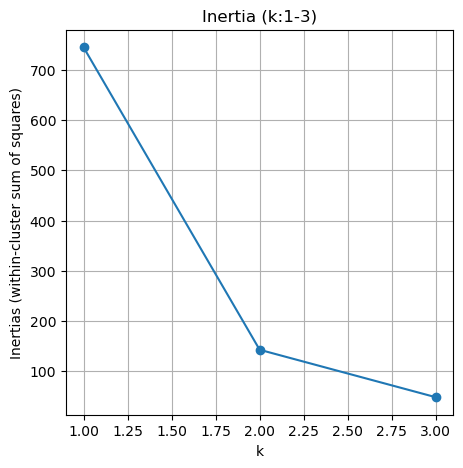

****************************************************************************************************
Total possible distinct initializations [36!/(1!*35!)]: 36
[k=1]
<Centroids's coordinations> : [(0.21944444444444441, 2.486111111111111)]
<inertia> : 879.779

Total possible distinct initializations [36!/(2!*34!)]: 630
[k=2]
<Centroids's coordinations> : [(-3.5, 2.6500000000000004), (3.938888888888889, 2.322222222222222)]
<inertia> : 380.779

Total possible distinct initializations [36!/(3!*33!)]: 7140
[k=3]
<Centroids's coordinations> : [(-3.6875, 3.1), (0.975, -0.7625), (4.925, 3.8333333333333335)]
<inertia> : 253.040



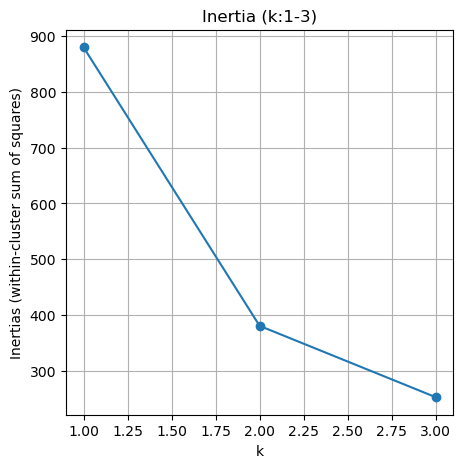

****************************************************************************************************
Total possible distinct initializations [360!/(1!*359!)]: 360
[k=1]
<Centroids's coordinations> : [(-0.03944111666666666, 3.359243691666667, -0.03867674166666667)]
<inertia> : 14593.562

Total possible distinct initializations [360!/(2!*358!)]: 64620
[k=2]
<Centroids's coordinations> : [(-2.5138291458333333, 2.5494572541666667, -2.5155796458333333), (4.909334941666667, 4.978816566666667, 4.915129066666666)]
<inertia> : 5295.915

Total possible distinct initializations [360!/(3!*357!)]: 7711320
[k=3]
<Centroids's coordinations> : [(-5.0465346250000005, 5.109353891666667, -5.0012598583333325), (0.018876333333333335, -0.010439383333333337, -0.029899433333333333), (4.909334941666667, 4.978816566666667, 4.915129066666666)]
<inertia> : 700.809



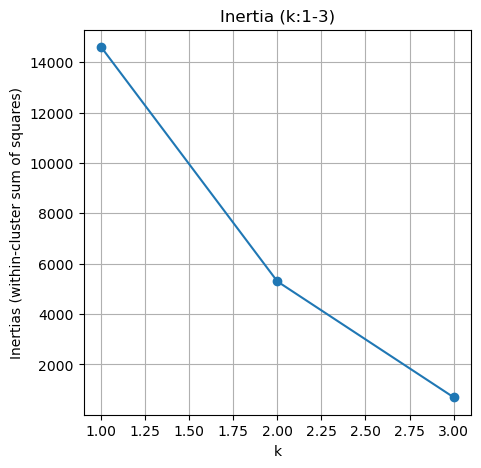

****************************************************************************************************
Total possible distinct initializations [60!/(1!*59!)]: 60
[k=1]
<Centroids's coordinations> : [(1.5964066666666665, 1.6163983333333334, 3.9969650000000003, 4.143698333333334, 1.4677833333333334)]
<inertia> : 14204.423

Total possible distinct initializations [60!/(2!*58!)]: 1770
[k=2]
<Centroids's coordinations> : [(-9.2104, 5.017686666666666, -5.293133333333333, 9.925613333333333, -9.202826666666665), (5.198675555555555, 0.48263555555555554, 7.093664444444444, 2.2163933333333334, 5.024653333333333)]
<inertia> : 6965.338

Total possible distinct initializations [60!/(3!*57!)]: 34220
[k=3]
<Centroids's coordinations> : [(-4.531803333333333, 2.4239566666666668, -2.6752666666666665, 4.817676666666667, -4.497496666666667), (5.2345999999999995, -8.520873333333332, 11.398473333333333, -3.1297466666666667, 4.7854600000000005), (10.214633333333333, 10.138553333333334, 9.939919999999999, 10.069

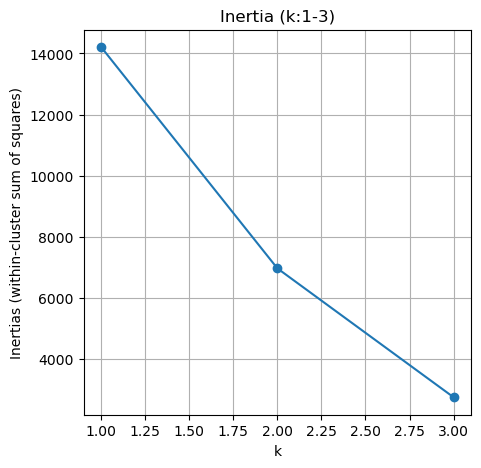

****************************************************************************************************


In [51]:
test_samples(samples = samples, ks = 3,nb_runs = 10)